In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/face-mask-detection/annotations/maksssksksss737.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss410.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss537.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss295.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss771.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss234.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss620.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss70.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss281.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss393.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss296.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss756.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss260.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss57.xml
/kaggle/input/face-mask-detection/annotations/maksssksksss224.xml
/kaggle/inpu

In [2]:
from glob import glob
import matplotlib.pyplot as plt
import cv2
import xml.etree.ElementTree as ET
import pandas as pd
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input
from sklearn.model_selection import train_test_split

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
masked_images = glob(os.path.join('/kaggle/input/face-mask-detection/images/*.png'))

In [4]:
len(masked_images)

853

In [5]:
masked_annotations = glob(os.path.join('/kaggle/input/face-mask-detection/annotations/*.xml'))

In [6]:
len(masked_annotations)

853

In [7]:
masked_annotations[0]

'/kaggle/input/face-mask-detection/annotations/maksssksksss737.xml'

In [8]:
annotations_data = pd.DataFrame()

for annotation in masked_annotations:
    tree = ET.parse(annotation)
    root = tree.getroot()
    counter = 0
    dic = dict()
    dic['Image_Name'] = root[1].text
    for i in range(4, len(root)):
        temp = []
        temp.append(root[i][0].text)
        for point in root[i][5]:
            temp.append(point.text)
        dic['wear_mask ' + str(counter)] = temp
        counter += 1

    annotations_data = pd.concat([annotations_data, pd.DataFrame([dic])], ignore_index=True)
    counter = 0

In [9]:
annotations_data = annotations_data.fillna(5)

In [10]:
annotations_data.head()

,Image_Name,wear_mask 0,wear_mask 1,wear_mask 2,wear_mask 3,wear_mask 4,wear_mask 5,wear_mask 6,wear_mask 7,wear_mask 8,...,wear_mask 105,wear_mask 106,wear_mask 107,wear_mask 108,wear_mask 109,wear_mask 110,wear_mask 111,wear_mask 112,wear_mask 113,wear_mask 114
0,maksssksksss737.png,"[with_mask, 28, 55, 46, 71]","[with_mask, 98, 62, 111, 78]","[mask_weared_incorrect, 159, 50, 193, 90]","[with_mask, 293, 59, 313, 80]","[with_mask, 352, 51, 372, 72]","[with_mask, 228, 53, 241, 73]",5,5,5,...,5,5,5,5,5,5,5,5,5,5
1,maksssksksss410.png,"[with_mask, 34, 153, 62, 176]","[with_mask, 88, 138, 111, 163]","[with_mask, 139, 207, 168, 234]","[with_mask, 116, 135, 135, 154]","[with_mask, 135, 103, 152, 121]","[mask_weared_incorrect, 101, 91, 115, 106]","[with_mask, 58, 109, 72, 127]","[with_mask, 56, 91, 65, 103]","[with_mask, 80, 81, 89, 91]",...,5,5,5,5,5,5,5,5,5,5
2,maksssksksss537.png,"[without_mask, 95, 177, 195, 295]",5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
3,maksssksksss295.png,"[with_mask, 92, 76, 168, 162]",5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
4,maksssksksss771.png,"[with_mask, 31, 109, 93, 161]","[with_mask, 83, 43, 119, 86]","[with_mask, 140, 70, 195, 128]","[with_mask, 280, 77, 366, 165]","[with_mask, 360, 10, 394, 46]",5,5,5,5,...,5,5,5,5,5,5,5,5,5,5


In [11]:
image_directory = '/kaggle/input/face-mask-detection/images/'
labels = []
data = []
classes = ["without_mask" , "mask_weared_incorrect" , "with_mask"]
labels = []

In [12]:
for index , row in annotations_data.iterrows():
    img = cv2.imread(os.path.join(image_directory , row[0]))
    cv2.resize(img , (255 , 255))
    for obj in row[1:]:
        if obj != 5:
            label = obj[0]
            obj[0] = obj[0].replace(str(label) , str(classes.index(label)))
            obj=[int(each) for each in obj]
            face = img[obj[2]:obj[4],obj[1]:obj[3]]
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)
            data.append(face)
            labels.append(label)
            if(label=="mask_weared_incorrect"):
                data.append(face)
                labels.append(label)

libpng warning: iCCP: Not recognizing known sRGB profile that has been edited


In [13]:
data = np.array(data , dtype="float32")
labels = np.array(labels)

In [14]:
print(data.shape)
print(labels.shape)

(4195, 224, 224, 3)
(4195,)


In [15]:
lb = LabelEncoder()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(data, labels,test_size=0.2, stratify=labels, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [17]:
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)

(2684, 224, 224, 3)
(2684, 3)
(672, 224, 224, 3)
(672, 3)
(839, 224, 224, 3)
(839, 3)


In [18]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam

In [19]:
model = Sequential() 

model.add(Flatten(input_shape = (224 , 224 , 3))) 
model.add(Dense(200, activation=LeakyReLU(alpha=0.3))) 
model.add(Dropout(0.5)) 

model.add(Dense(50, activation=LeakyReLU(alpha=0.3))) 
model.add(Dropout(0.3)) 

model.add(Dense(3 , activation = 'softmax'))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 200)               30105800  
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                10050     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 153       
                                                                 
Total params: 30,116,003
Trainable params: 30,116,003
No

In [21]:
INIT_LR = 1e-4
EPOCHS = 15
BS = 1

In [22]:
from keras.optimizers import Adam

# Define the learning rate schedule
def lr_schedule(epoch):
    lr = INIT_LR
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    return lr

# Create a custom Adam optimizer with the learning rate schedule
opt = Adam(learning_rate=INIT_LR)

# Compile the model with the custom optimizer
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])


In [23]:
opt = Adam(lr = INIT_LR , decay = INIT_LR / EPOCHS)
model.compile(loss = "categorical_crossentropy" , optimizer = opt , metrics = ["accuracy"])
H = model.fit(X_train, Y_train , steps_per_epoch = len(X_train) // BS , validation_data = (X_val , Y_val) , validation_steps = len(X_val) // BS , epochs = EPOCHS)

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/15
2684/2684 [==============================] - 26s 9ms/step - loss: 15.4875 - accuracy: 0.7578 - val_loss: 13.9646 - val_accuracy: 0.8438
Epoch 2/15
2684/2684 [==============================] - 22s 8ms/step - loss: 14.4580 - accuracy: 0.8152 - val_loss: 6.6809 - val_accuracy: 0.8943
Epoch 3/15
2684/2684 [==============================] - 22s 8ms/step - loss: 12.2945 - accuracy: 0.8376 - val_loss: 4.2017 - val_accuracy: 0.8929
Epoch 4/15
2684/2684 [==============================] - 23s 9ms/step - loss: 10.9121 - accuracy: 0.8521 - val_loss: 5.5899 - val_accuracy: 0.8824
Epoch 5/15
2684/2684 [==============================] - 22s 8ms/step - loss: 10.5892 - accuracy: 0.8532 - val_loss: 9.2637 - val_accuracy: 0.8676
Epoch 6/15
2684/2684 [==============================] - 22s 8ms/step - loss: 8.8302 - accuracy: 0.8662 - val_loss: 8.0109 - val_accuracy: 0.9018
Epoch 7/15
2684/2684 [==============================] - 22s 8ms/step - loss: 9.4783 - accuracy: 0.8636 - val_loss: 7.5023 - 

In [25]:
from sklearn.metrics import accuracy_score
from sklearn import metrics
import numpy as np
import seaborn as sns

In [26]:
y_pred = model.predict(X_test)

27/27 [==============================] - 0s 15ms/step


In [27]:
y_pred_new = np.argmax(y_pred , axis = 1) # To get the index (The class numer) of the predicted class
y_test_new = np.argmax(Y_test , axis = 1)

In [28]:
y_pred_new[:10]

array([2, 1, 1, 1, 1, 1, 1, 1, 1, 1])

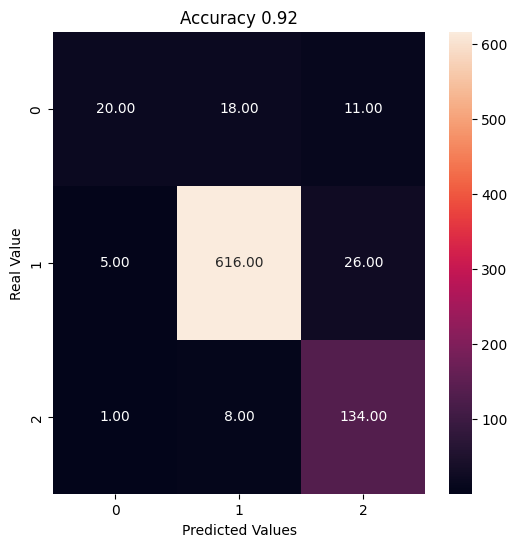

In [30]:
Confusion_Mtrx = metrics.confusion_matrix(y_test_new , y_pred_new)
#true_positive , false_positive, false_negative, true_negative = Confusion_Mtrx.ravel()

plt.figure(figsize=(6,6))
sns.heatmap(Confusion_Mtrx, annot=True, fmt=".2f");
plt.ylabel('Real Value');
plt.xlabel('Predicted Values');
plt.title('Accuracy {0:.2f}'.format(metrics.accuracy_score(y_test_new, y_pred_new)));